In [54]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, wilcoxon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import matplotlib.gridspec as gridspec
import panel as pn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from collections import defaultdict
from scipy.stats import sem
from scipy.stats import ttest_rel


# file path
file_name = '/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/data/organized_data/organized_data.csv'

In [55]:
df = pd.read_csv(file_name)

In [56]:
# Calculate median trial movements for each trial

# Convert 'slider_values_rescaled' to lists of numeric values
df['slider_values_numeric'] = df['slider_values_rescaled'].apply(lambda x: [float(i) for i in x.split(',')] if pd.notna(x) else [])

# Calculate the mean and median for each trial
df['trial_mean_rescaled'] = df['slider_values_numeric'].apply(lambda x: np.mean(x) if x else np.nan)
df['trial_median_rescaled'] = df['slider_values_numeric'].apply(lambda x: np.median(x) if x else np.nan)

In [57]:
# Define the sigmoid function
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

**x**: the input variable (independent variable). Here, x represents the speech_rate conditions for which you want to predict trial_median_rescaled.

**a**: controls the steepness or growth rate of the curve.
Larger values of *a* make the transition (or "drop") steeper, while smaller values make it more gradual.
<br /> Here, *curve_fit* will estimate  *a* based on the data, determining how steep the transition in trial_median_rescaled is relative to speech_rate.

**b**: the center or midpoint of the curve along the x-axis (in this case, the speech_rate axis).
<br /> Here, it indicates the value of speech_rate where the curve is halfway between its minimum and maximum values.
<br /> If *b* is estimated as, say, 3, this would imply that the main transition or "drop" in trial_median_rescaled occurs around speech_rate = 3 -> spoiler: it is the case here

**c**: the maximum value or asymptote of the curve. It represents the highest value that trial_median_rescaled can reach as speech_rate becomes very low.
<br /> It essentially "scales" the output, stretching or compressing the sigmoid curve vertically.
<br /> Here, *curve_fit* will estimate *c* to fit the range of trial_median_rescaled values in the data.

The function is: 
$$
\frac{c}{1 + \exp(-a \cdot (x - b))}
$$

In [63]:
# Total number of trials in the dataset
total_trials = len(df)
total_trials

2750

In [ ]:
# score per fold per subject and then average the scores across folds for each subject 

**The version below** plots a smooth sigmoid curve across a broader range (1 to 5). It provides a theoretical view of the sigmoid model's behavior over this range, even beyond the observed data points. 
<br /> It uses a new range of speech_rate values defined by sigmoid_x_range = np.linspace(1, 5, 100), which creates 100 evenly spaced points between 1 and 5.
<br /> The sigmoid model is then plotted over this wider range, allowing you to see the full shape of the sigmoid curve.
<br /> This smooth curve is generated using the parameters of the sigmoid function that were estimated for each fold.
<br /> This approach shows a generalized or theoretical curve based on the fitted sigmoid parameters, rather than plotting only on the specific validation data points for each fold.



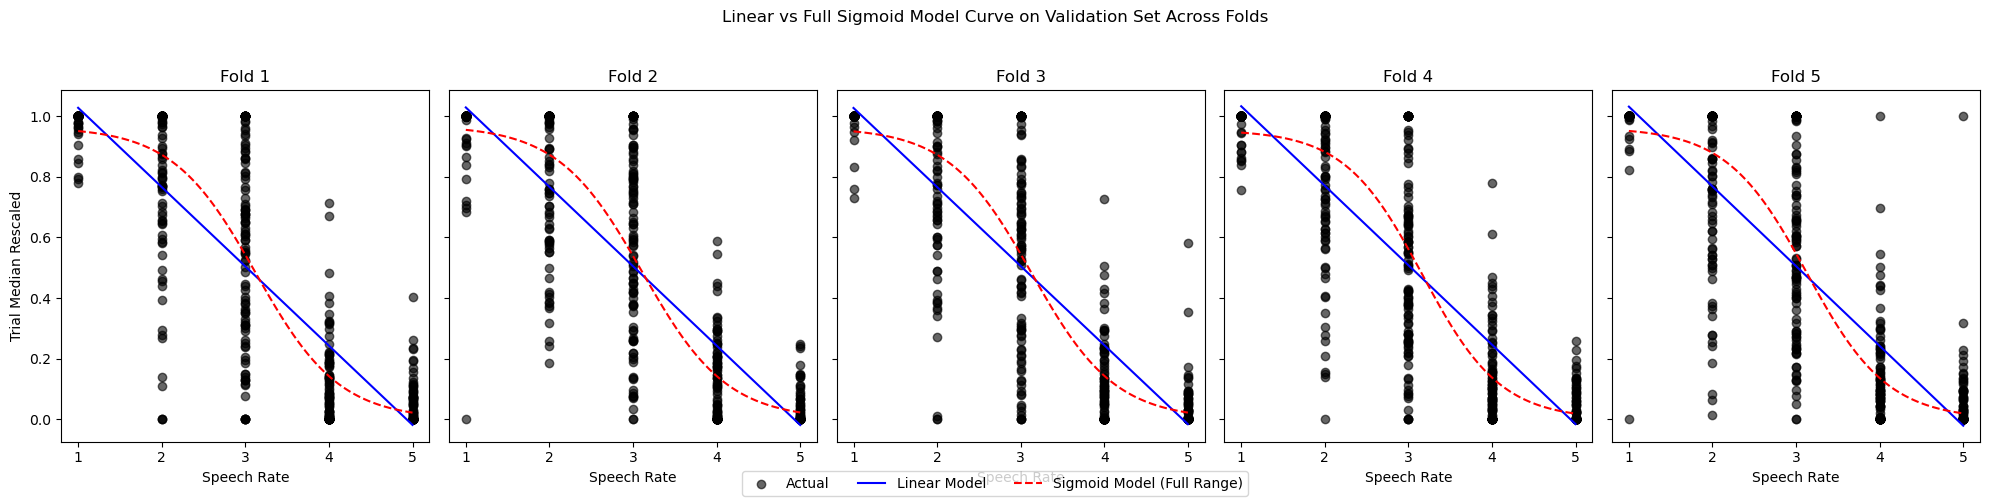

In [59]:
# plot the model fits per fold

# Set up a multi-panel plot with 5 panels (one for each fold)
fig, axs = plt.subplots(1, n_splits, figsize=(20, 5), sharey=True)
fig.suptitle("Linear vs Full Sigmoid Model Curve on Validation Set Across Folds")

# Define a wider range for plotting the sigmoid curve
sigmoid_x_range = np.linspace(1, 5, 100)  # Wider range from 1 to 5

# Plot each fold in a separate panel
for fold_data in results:
    fold = fold_data['fold']
    ax = axs[fold - 1]  # Select subplot for the current fold

    # Convert predictions to NumPy arrays if they are not already
    linear_preds = np.array(fold_data['linear_preds'])
    speech_rate = np.array(fold_data['speech_rate'])
    actual_values = np.array(fold_data['actual'])

    # Generate sigmoid predictions over the wider range for a smooth curve
    if fold_data['sigmoid_params'] is not None:
        full_sigmoid_curve = sigmoid(sigmoid_x_range, *fold_data['sigmoid_params'])
    else:
        full_sigmoid_curve = np.full_like(sigmoid_x_range, np.nan)

    # Plot actual data points and linear predictions on the actual data points
    ax.scatter(speech_rate, actual_values, label='Actual', color='black', alpha=0.6)
    ax.plot(speech_rate[np.argsort(speech_rate)], linear_preds[np.argsort(speech_rate)], 
            label='Linear Model', linestyle='-', color='blue')

    # Plot the full sigmoid curve over the wider range
    ax.plot(sigmoid_x_range, full_sigmoid_curve, label='Sigmoid Model (Full Range)', linestyle='--', color='red')
    
    # Set titles and labels
    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Speech Rate')
    if fold == 1:
        ax.set_ylabel('Trial Median Rescaled')

# Add a single legend outside the subplots
fig.legend(['Actual', 'Linear Model', 'Sigmoid Model (Full Range)'], loc='lower center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title and legend
plt.show()

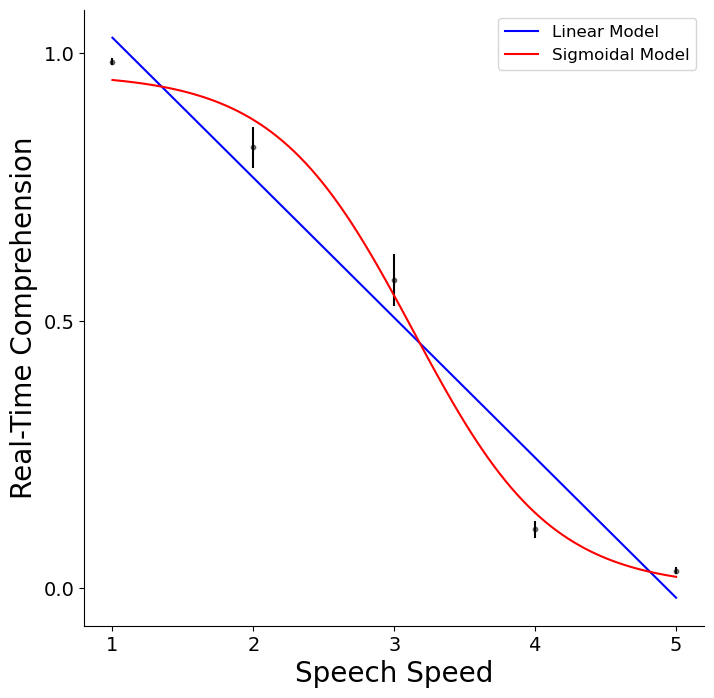

In [69]:
# Plot the model fits across folds, the error bars are the error over subjects and over trials

# Collect all predictions and actuals across folds into a single DataFrame
all_data = []
for fold_data in results:
    fold = fold_data['fold']
    all_data.append(pd.DataFrame({
        'fold': fold,
        'participant': fold_data['participant'],  # Ensure participant data is included
        'speech_rate': fold_data['speech_rate'],
        'actual': fold_data['actual'],
        'linear_preds': fold_data['linear_preds'],
        'sigmoid_preds': fold_data['sigmoid_preds']
    }))

# Concatenate data from all folds
all_data_df = pd.concat(all_data, ignore_index=True)

# Calculate the mean for each speech rate (same as before)
mean_values = all_data_df.groupby('speech_rate')['actual'].mean().reset_index()
mean_values.columns = ['speech_rate', 'actual_mean']

# Calculate the error by combining trial and subject-level variability
subject_trial_means = all_data_df.groupby(['speech_rate', 'participant'])['actual'].mean().reset_index()
subject_trial_sem = subject_trial_means.groupby('speech_rate')['actual'].apply(sem).reset_index()
subject_trial_sem.columns = ['speech_rate', 'actual_sem']

# Merge the mean and sem data
averages_df = pd.merge(mean_values, subject_trial_sem, on='speech_rate')

# Calculate the mean for linear model predictions as before
averages_df['linear_mean'] = all_data_df.groupby('speech_rate')['linear_preds'].mean().values

# Plot the averaged data
plt.figure(figsize=(8, 8))

# Plot only the error bars with alpha=1 (exclude from legend)
plt.errorbar(
    averages_df['speech_rate'], averages_df['actual_mean'], yerr=averages_df['actual_sem'],
    fmt='none', ecolor='black', alpha=1, capsize=0, label=None  # Exclude from legend
)

# Plot the average actual points with a separate alpha (exclude from legend)
plt.scatter(
    averages_df['speech_rate'], averages_df['actual_mean'],
    color='black', alpha=0.5, label=None, s=10  # Exclude from legend
)

# Plot the averaged linear model predictions as a line (with label for the legend)
plt.plot(
    averages_df['speech_rate'], averages_df['linear_mean'],
    color='blue', linestyle='-', label='Linear Model'
)

# Generate a smooth sigmoid curve based on the overall average sigmoid parameters
sigmoid_x_range = np.linspace(1, 5, 100)

# Fit the sigmoid model on the averages to get a smooth curve over a wider range
p_sigmoid_avg, _ = curve_fit(
    sigmoid, averages_df['speech_rate'], averages_df['actual_mean'],
    p0=[1, np.mean(averages_df['speech_rate']), max(averages_df['actual_mean'])]
)
sigmoid_avg_curve = sigmoid(sigmoid_x_range, *p_sigmoid_avg)

# Plot the fitted sigmoid curve (with label for the legend)
plt.plot(sigmoid_x_range, sigmoid_avg_curve, color='red', linestyle='-', label='Sigmoidal Model')

# Add a legend for the blue and red lines
plt.legend(loc='upper right', fontsize=12)  # Adjust the location and font size as needed


# Remove the top and right spines
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-axis ticks to only show speech rates
unique_speech_rates = sorted(all_data_df['speech_rate'].unique())
ax.set_xticks(unique_speech_rates)

# Set y-axis ticks to only 0, 0.5, and 1
ax.set_yticks([0, 0.5, 1])

# Set title, labels, and font sizes
plt.title("", fontsize=25)
plt.xlabel("Speech Speed", fontsize=20)
plt.ylabel("Real-Time Comprehension", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the legend  Maybe we don't need the legend for this? The caption should be enough
plt.show()

In [61]:
# Calculate r values for each subject by averaging correlations across folds

# Aggregate data across folds for each participant
subject_correlation_data = {}

# Loop through each fold's results to aggregate predictions by participant
for fold_data in results:
    for participant, actual, linear_pred, sigmoid_pred in zip(
            fold_data['participant'], fold_data['actual'], fold_data['linear_preds'], fold_data['sigmoid_preds']):
        
        if participant not in subject_correlation_data:
            subject_correlation_data[participant] = {'actual': [], 'linear': [], 'sigmoid': []}
        
        # Append actual and predicted values for each participant across folds
        subject_correlation_data[participant]['actual'].append(actual)
        subject_correlation_data[participant]['linear'].append(linear_pred)
        subject_correlation_data[participant]['sigmoid'].append(sigmoid_pred)

# Calculate average correlation per participant across folds
subject_correlations = []
for participant, data in subject_correlation_data.items():
    # Convert lists to arrays for Pearson correlation calculation
    actual_values = np.array(data['actual'])
    linear_preds = np.array(data['linear'])
    sigmoid_preds = np.array(data['sigmoid'])
    
    # Calculate correlations
    if len(actual_values) > 1:  # Ensure there's enough data for correlation
        r_linear, _ = pearsonr(actual_values, linear_preds)
        r_sigmoid, _ = pearsonr(actual_values, sigmoid_preds)
        # Store results for each participant
        subject_correlations.append({'participant': participant, 'r_linear': r_linear, 'r_sigmoid': r_sigmoid})

# Convert to DataFrame for statistical testing
subject_correlations_df = pd.DataFrame(subject_correlations)

# Wilcoxon tests to compare model correlations to chance level (r > 0) and each other
print("Wilcoxon test for correlation > 0 (chance level):")
wilcoxon_linear = wilcoxon(subject_correlations_df['r_linear'] - 0)
wilcoxon_sigmoid = wilcoxon(subject_correlations_df['r_sigmoid'] - 0)
print(f"Linear model: statistic={wilcoxon_linear.statistic}, p-value={wilcoxon_linear.pvalue}")
print(f"Sigmoid model: statistic={wilcoxon_sigmoid.statistic}, p-value={wilcoxon_sigmoid.pvalue}")

print("\nWilcoxon test for difference between models (rsigmoid > rlinear):")
wilcoxon_diff = wilcoxon(subject_correlations_df['r_sigmoid'], subject_correlations_df['r_linear'], alternative='greater')
print(f"Sigmoid vs. Linear model correlation: statistic={wilcoxon_diff.statistic}, p-value={wilcoxon_diff.pvalue}")


Wilcoxon test for correlation > 0 (chance level):
Linear model: statistic=0.0, p-value=4.76837158203125e-07
Sigmoid model: statistic=0.0, p-value=4.76837158203125e-07

Wilcoxon test for difference between models (rsigmoid > rlinear):
Sigmoid vs. Linear model correlation: statistic=199.0, p-value=0.008600473403930664


In [174]:
# the mean and standard deviation of r_linear and r_sigmoid

print("Linear model correlations: mean =", np.mean(subject_correlations_df['r_linear']), 
      ", std =", np.std(subject_correlations_df['r_linear']))
print("Sigmoid model correlations: mean =", np.mean(subject_correlations_df['r_sigmoid']), 
      ", std =", np.std(subject_correlations_df['r_sigmoid']))


Linear model correlations: mean = 0.8944426575465283 , std = 0.030592401793087268
Sigmoid model correlations: mean = 0.9085730277590784 , std = 0.046609016754768445


In [176]:
# Alternative: A paired t-test to compare correlation values for the linear and sigmoid models. 
# not as robust as the Wilcoxon test for non-normal data, but just to see if it confirms.

t_stat, p_val = ttest_rel(subject_correlations_df['r_sigmoid'], subject_correlations_df['r_linear'])
print(f"Paired t-test (rsigmoid vs rlinear): t-statistic={t_stat}, p-value={p_val}")

Paired t-test (rsigmoid vs rlinear): t-statistic=2.337873411730097, p-value=0.029369855110227702


In [177]:
# Check for any participants with outlier correlation values for either model.

print(subject_correlations_df[['participant', 'r_linear', 'r_sigmoid']].describe())

        r_linear  r_sigmoid
count  22.000000  22.000000
mean    0.894443   0.908573
std     0.031312   0.047706
min     0.796811   0.739639
25%     0.881348   0.907455
50%     0.900215   0.921162
75%     0.917802   0.935353
max     0.934157   0.961126
